# Simulated Maximum Likelihood with PFJAX

**Pranav Subramani, Martin Lysy -- University of Waterloo**

**March 31, 2022**

## Summary

In this module we demontrate how to maximize the marginal likelihood for the state-space model,

$$
\begin{aligned}
\Ell(\tth) & = p(\yy_{0:T} \mid \tth) \\
& = \int \prod_{t=0}^T p(\yy_t \mid \xx_t, \tth) \times \prod_{t=1}^T p(\xx_t \mid \xx_{t-1}, \tth) \times p(\xx_0 \mid \tth)\, d \xx_{0:T},   
\end{aligned}
$$

using a particle filter approximation for $\Ell(\tth)$.  In particular:

- We obtain particle filter estimates of $\ell(\tth) = \log \Ell(\tth)$ and $\nabla \ell(\tth)$ in order to conduct stochastic optimization in search of $\hat \tth = \argmax_{\tth} \ell(\tth)$.

- We obtain a particle filter estimate of $\nabla^2 \ell(\tth)$ to be used for variance estimation, e.g., for calculating standard errors.

## Example: Brownian Motion with Drift

The model is
$$
\begin{aligned}
x_0 & \sim \pi(x_0) \propto 1 \\
x_t & \sim \N(x_{t-1} + \mu \dt, \sigma^2 \dt) \\
y_t & \sim \N(x_t, \tau^2),
\end{aligned}
$$

with $\tth = (\mu, \sigma, \tau)$.  Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.  In this case, the marginal likelihood is defined as 

$$
\Ell(\tth) = p(\yy_{1:T} \mid \yy_0, \tth)
$$

rather than by $p(\yy_{0:T} \mid \tth)$.  The reason is that the latter expression requires one to integrate over $x_0 \sim \pi(x_0)$, which can only be done when $\pi(x_0)$ is a proper prior.  However, for our choice of $\pi(x_0) \propto 1$ this is not the case.  On the other hand, $p(\yy_{1:T} \mid y_0, \tth)$ only requires us to integrate over $p(x_0 \mid y_0, \tth)$, which only requires this distribution to be proper, as is the case here.

Brownian motion with drift is a simple model that will serve as a benchmark for further experiments. Note that in this particular model, we have access to the closed form of $\Ell(\tth)$ (see below for derivation). Since our method is an approximation method, it will serve as a reasonable sanity check and debugging tool to ensure that our method is not only technically sound, but also empirically verifiable.

## Simulate Data

Text(0.5, 1.0, 'Latent Variable(x_state) and Observation(y_meas)')

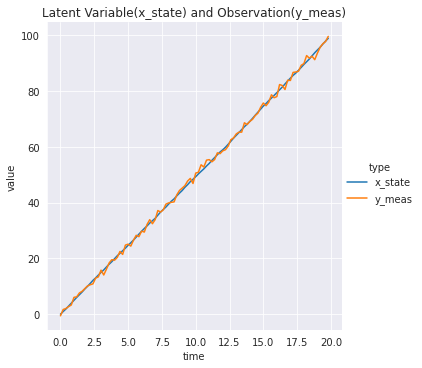

In [1]:
import numpy as np
from functools import partial
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp

import pfjax as pf
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta_true = jnp.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = 0.

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, key, n_obs, x_init, theta_true)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)")


## Check Particle Filter Approximations

Let $\hat \ell_N(\tth)$ denote the particle filter estimate of $\ell(\tth)$ with $N$ particles, and similar notations for $\widehat{\nabla \ell}_N(\tth)$ and $\widehat{\nabla^2 \ell}_N(\tth)$.  Here we want to check that

$$
\begin{aligned}
\hat \ell_N(\tth) & \to \ell(\tth) \\
\widehat{\nabla \ell}_N(\tth) & \to \nabla \ell(\tth) \\
\widehat{\nabla^2 \ell}_N(\tth) & \to \nabla^2 \ell(\tth)
\end{aligned}
$$

as $N \to \infty$.  The usual way of estimating the score and Hessian functions $\nabla \ell(\tth)$ and $\nabla^2 \ell(\tth)$ is described in e.g., Cappe et al (2005), Poyiadjis et al (2011).  Here we would like leverage the power of the JAX autodiff engine to just differentiate through the particle filter, i.e,. $\widehat{\nabla \ell}_N(\tth) = \nabla \hat{\ell}_N(\tth)$ and $\widehat{\nabla^2 \ell}_N(\tth) = \nabla^2 \hat{\ell}_N(\tth)$.

### Loglikelihood Check

~~We'll proceed on the negative scale, which converts the MLE to a minimization problem for which most optimization algorithms are naturally defined.  Also, we'll convert the parameter to an unconstrained scale, $\pph = (\mu, \log \sigma, \log \tau)$.~~

**Warning:** The code below makes heavy use of global variables, thus violating the functional programming paradigm of JAX.  Changing these global variables after jitting will lead to incorrect results.

In [2]:
def to_phi(theta):
    """
    Helper function to convert theta to phi.
    """
    return jnp.array([theta[0], jnp.log(theta[1]), jnp.log(theta[2])])

def to_theta(phi):
    """
    Helper function to convert phi to theta.
    """
    return jnp.array([phi[0], jnp.exp(phi[1]), jnp.exp(phi[2])])


def bm_negloglik_exact(theta, y_meas):
    """
    Exact negative loglikelihood of the BM model.
    """
    return -bm_model.loglik_exact(y_meas=y_meas, theta=theta)

def bm_negloglik_pf(theta, y_meas, key, n_particles):
    """
    Particle filter approximation of the negative loglikelihood.
    """
    pf_out = pf.particle_filter(
        model=bm_model,
        key=key,
        y_meas=y_meas,
        theta=theta,
        n_particles=n_particles
    )
    return -pf.particle_loglik(pf_out['logw'])

Here we'll content ourselves with a visual assessment using projection plots about the true parameter value.

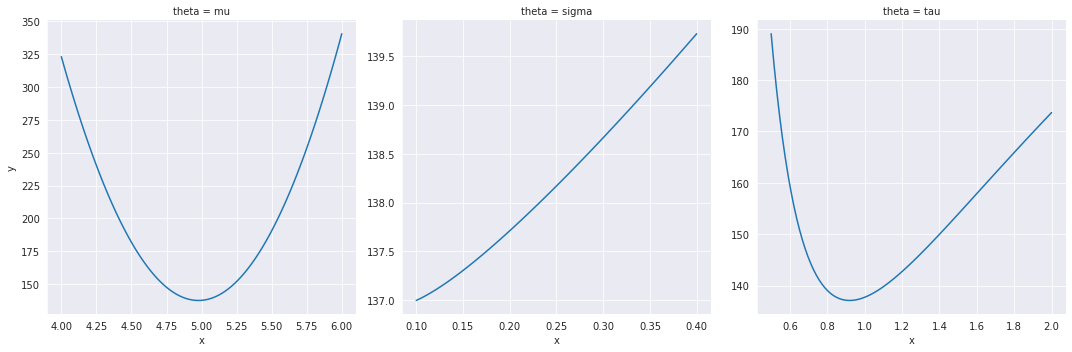

In [ ]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for `projplot.projxvals()` and `projplot.projdata()`.
    
    Won't need this for upcoming interface of projplot.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

# plot exact likelihood
theta_lims = jnp.array([[4., 6.], [.1, .4], [.5, 2]])
# phi_true = to_phi(theta_true)
# phi_lims = to_phi(theta_lims)

theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
df_exact = proj_data(jax.jit(partial(bm_negloglik_exact, y_meas=y_meas)),
                    theta_true, theta_lims, theta_names, n_pts=n_pts)

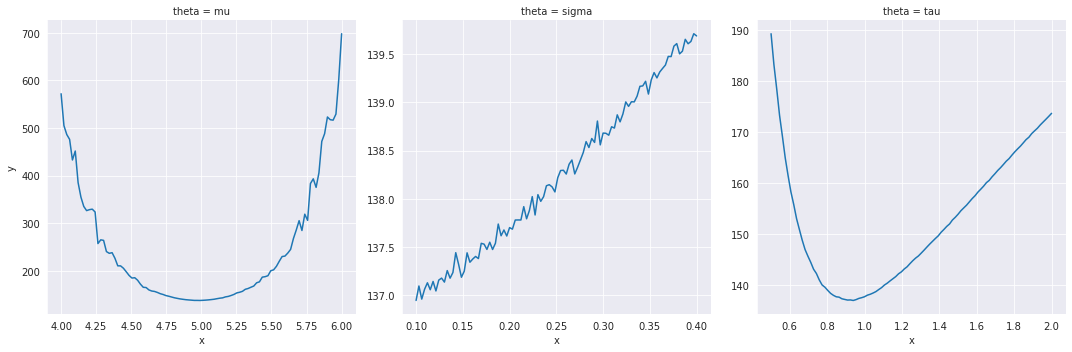

In [ ]:
n_particles = 10000

bm_nll = jax.jit(partial(bm_negloglik_pf, y_meas=y_meas,
                 n_particles=n_particles, key=key))

df_pf = proj_data(bm_nll,
                  theta_true, theta_lims, theta_names)

Text(0.5, 0.98, 'Projection Plots using Closed-Form Latents')

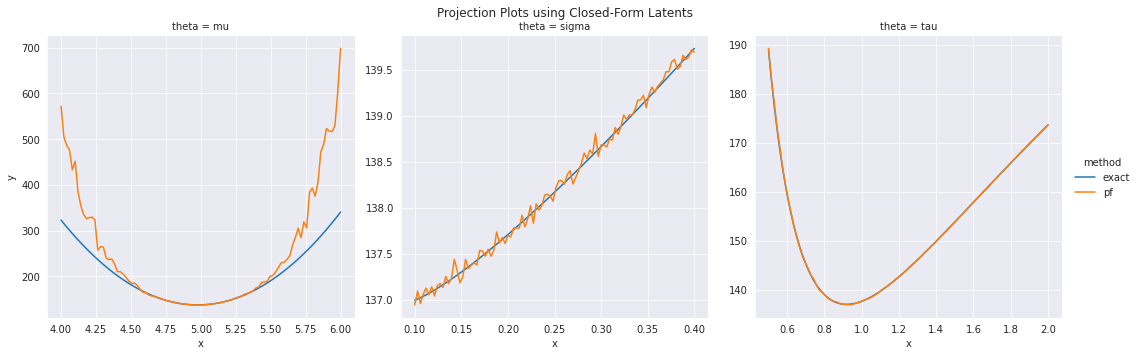

In [ ]:
plot_df = pd.concat([df_exact, df_pf], ignore_index=True)
plot_df["method"] = np.array(["exact"] * len(df_exact["theta"]) + ["pf"] * len(df_pf["theta"]))

rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", 
    col="theta",
    hue="method",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots using Closed-Form Latents')

**Conclusion:** It seems that the particle filter reasonably approximates $\ell(\tth)$ when $\mu$ is at its true value.  It doens't do so well when $\mu$ is far from its true value.  This may have to do with particle degeneracy in that case.

### Check Score Function

For simplicity we'll just check it at the true value used for simulation.

In [7]:
n_particles = 10000

bm_score_exact = jax.jit(jax.grad(partial(bm_negloglik_exact, y_meas=y_meas)))
# bm_score_pf = jax.jit(jax.grad(partial(bm_negloglik_pf, y_meas=y_meas, n_particles=n_particles, key=key)))

print(bm_score_exact(theta_true))
# print(bm_score_pf(theta_true))

[ 8.732834  8.744178 14.441429]


**Conclusion:** This really doesn't seem to be working!  Could it be that $\nabla \hat \ell_N(\tth) \not \to \nabla \ell(\tth)$?

## Score Using Cappe/Doucet Method

In light of the above, we consider a published estimator now.  This takes gradients first and propagates them using an accumulator.

In [8]:
def accumulate_score(x_prev, x_curr, y_curr, theta):
    """
    Accumulator for the score function.

    Needs to be on the original scale because that's the argument signature `particle_filter2()` expects.
    """
    def alpha(theta):
        return -bm_model.state_lpdf(x_curr=x_curr, x_prev=x_prev, theta=theta) - \
            bm_model.meas_lpdf(y_curr=y_curr, x_curr=x_curr, theta=theta)
    return jax.grad(alpha)(theta)

def accumulate_hess(x_prev, x_curr, y_curr, theta):
    def alpha(theta):
        return -bm_model.state_lpdf(x_curr=x_curr, x_prev=x_prev, theta=theta) - \
            bm_model.meas_lpdf(y_curr=y_curr, x_curr=x_curr, theta=theta)
    return jax.jacfwd(jax.jacrev(alpha))(theta)


# bm_score_pf = jax.jit(lambda theta:
#                       pf.particle_filter2(model=bm_model, key=key, y_meas=y_meas,
#                                           theta=theta, n_particles=n_particles,
#                                           accumulator=accumulate_score)["accumulate_out"])
bm_score_pf = jax.jit(lambda theta:
                      pf.particle_filter2(model=bm_model, key=key, y_meas=y_meas,
                                          theta=theta, n_particles=n_particles,
                                          accumulator=accumulate_hess)["accumulate_out"])

print(bm_score_pf(theta_true))

ValueError: Incompatible shapes for broadcasting: ((10000, 3, 3), (1, 10000, 1))

## Older Code Below

In [ ]:
# @jax.jit
def bm_loglik(theta, y_meas, dt):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1  # conditioning on y_0
    t_meas = jnp.arange(1, n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)


print(bm_loglik(jnp.array([5, 1.2, 0]), y_meas, dt))
print(bm_model.loglik_exact(y_meas, jnp.array([5, 1.2, 0])))

-389.7961270365492
-389.7961270365492


Given that the algorithm we wish to use is gradient ascent (or descent on the negative log likeloood), we note that these plots appear to be amenable to gradient based optimization.

We would also like to now plot the particle filter log likelihood in the same domain for the parameters. Here, we are using the estimated latent variables compared to the exact ones and as a result, we would expect to see more noise in the parameter values.

In [ ]:
import optax
from functools import partial
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # First we obtain the gradients of the gradient function with respect to the `grad_fun`.
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    # Updating the params with respect to the mask.
    params_update = jnp.where(mask, params_update, 0)
    # Applying the updates to the parameters except for those that are masked.
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def stoch_opt(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params = update_fn(params, subkey, opt_state)
    return params 
    

def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    """
    Evaluate the bootstrap particle filter estimate of the negative log-likelihood at parameter values \theta. Runs the particle filter for each timestep in y_meas and sums the log-weights for each particle
    Args:
        theta: A `jnp.array` that represents the values of the parameters on the log scale.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
    Returns:
        Estimate of the negative log-likelihood evaluated at \theta. 
    """
    theta_reg = jnp.array([theta[0], jnp.exp(theta[1]), jnp.exp(theta[2])])
    ret = pf.particle_filter(model, key, y_meas, theta_reg, n_particles)
    sum_particle_lweights = pf.particle_loglik(ret['logw'])
    return -sum_particle_lweights


def hessian_averaging_alg(optima, key, grad_fun, y_meas, model, iterations=100, n_particles=500):
    hessian_fn = jax.jit(jax.jacfwd(jax.jacrev(partial(grad_fun, n_particles=n_particles, model=model))))
    keys = random.split(key, iterations)
    hess = jax.vmap(lambda i: hessian_fn(optima, keys[i], y_meas=y_meas))(jnp.arange(iterations))
#     hess = hessian_fn(optima, key, n_particles=n_particles, y_meas=y_meas, model=model)
#     keys = random.split(key, iterations)
#     j = 2
#     for i in range(len(keys)):
#         # while(jnp.all(jnp.linalg.eigvals(hess) >= 0)): 
#         new_hess = hessian_fn(optima, keys[i], n_particles=n_particles, y_meas=y_meas, model=model)
#         hess = (((j - 1) / (j)) * hess) + ((1 / j) * new_hess)
#         j += 1
    return hess 

Now, we run the stochastic optimization on the model for 1000 iterations to see whether the local optima that we initialize the model to is stable enough for the model to not diverge from there. Please note that we may also increase the number of particles greatly to improve the efficacy of the method given that our approximation is exact as the number of particles approaches infinity.

In [ ]:
params = stoch_opt(bm_model, jnp.array([5.0, jnp.log(0.2), jnp.log(1.0)]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1]))
params_reg = jnp.array([params[0], jnp.exp(params[1]), jnp.exp(params[2])])
params_reg

/Users/mlysy/miniconda3/envs/jaxenv/lib/python3.8/site-packages/jax/interpreters/xla.py:803: UserWarning: Some donated buffers were not usable: f64[3]{0}.
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/notebooks/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


DeviceArray([4.914     , 0.07765822, 0.94364996], dtype=float64)

In [ ]:
# Hessian of the true loglik using the estimated parameter values 
temp = bm_loglik(params_reg, y_meas, dt)
# hess = jax.jacfwd(jax.jacrev(bm_loglik))(y_meas, dt, params_reg)
# hess.shape
hess_fn = jax.jacfwd(jax.jacrev(bm_loglik))
hess = hess_fn(np.array([5.0, 0.07, 1.0]), y_meas, dt)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print(temp)
print(hess)

False
[[-1692.05567312  2115.28418422   148.35760417]
 [ 2115.28418422 -1419.33950167  -177.05218295]
 [  148.35760417  -177.05218295  -178.15891076]]


In [ ]:
# Maximizing `bm_loglik_exact`

def max_bm_loglik_exact(theta_init, iterations, eps=0.01):
    grad_likelihood = jax.grad(bm_loglik)
    for i in range(iterations):
        theta_init = eps * grad_likelihood(theta_init, y_meas, dt) + theta_init
    print(theta_init)
    return theta_init


# We try an alternate optimizer as well apart from gradient ascent which is the `jax.scipy.optimize.minimize`
from jax.scipy import optimize
def min_bm_loglik(theta):
    return -1.0 * bm_loglik(theta, y_meas, dt)

bfgs_theta_converged = optimize.minimize(min_bm_loglik, jnp.array([5.0, jnp.log(0.054), jnp.log(1.0)]), method='BFGS')

# theta_hat_exact is the parameter optimal on the unconstrained scale.
theta_hat_exact = max_bm_loglik_exact(jnp.array([5.0, jnp.log(0.054), jnp.log(1.0)]), 1000, 0.01)
# theta_hat_exact_orig_scale is the parameter optimal on the original scale.
theta_hat_exact_orig_scale = jnp.array([theta_hat_exact[0], jnp.exp(theta_hat_exact[1]), jnp.exp(theta_hat_exact[2])])
print(theta_hat_exact_orig_scale)
print(bfgs_theta_converged)

[ 5.0567403 -2.9386334  0.       ]
[5.0567403  0.05293802 1.        ]
OptimizeResults(x=DeviceArray([ 5.0567575, -2.9386413,  0.       ], dtype=float32), success=DeviceArray(False, dtype=bool), status=DeviceArray(3, dtype=int32, weak_type=True), fun=DeviceArray(167.52411, dtype=float32), jac=DeviceArray([-2.861023e-05, -0.000000e+00, -0.000000e+00], dtype=float32), hess_inv=DeviceArray([[0.39312333, 0.04609951, 0.        ],
             [0.0460995 , 0.02348395, 0.        ],
             [0.        , 0.        , 1.        ]], dtype=float32), nfev=DeviceArray(41, dtype=int32, weak_type=True), njev=DeviceArray(41, dtype=int32, weak_type=True), nit=DeviceArray(7, dtype=int32, weak_type=True))


In [ ]:
theta_bfgs_conv = bfgs_theta_converged.x
theta_bfgs_conv = jnp.array([theta_bfgs_conv[0], jnp.exp(theta_bfgs_conv[1]), jnp.exp(theta_bfgs_conv[2])])
print(theta_bfgs_conv)

[5.0567575 0.0529376 1.       ]


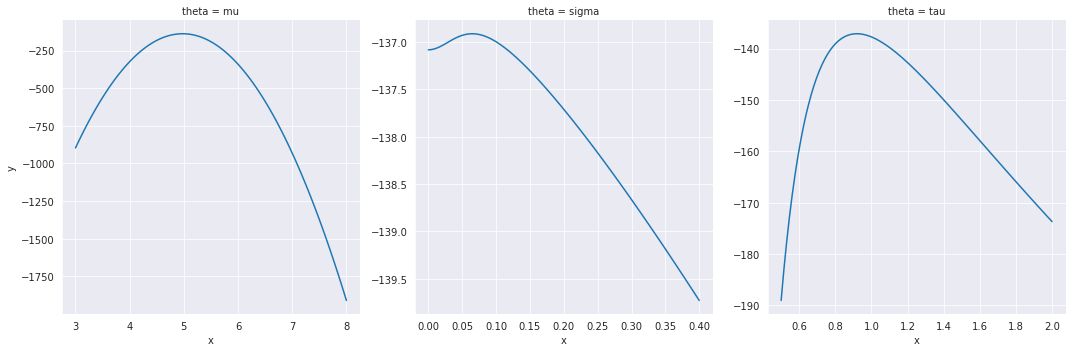

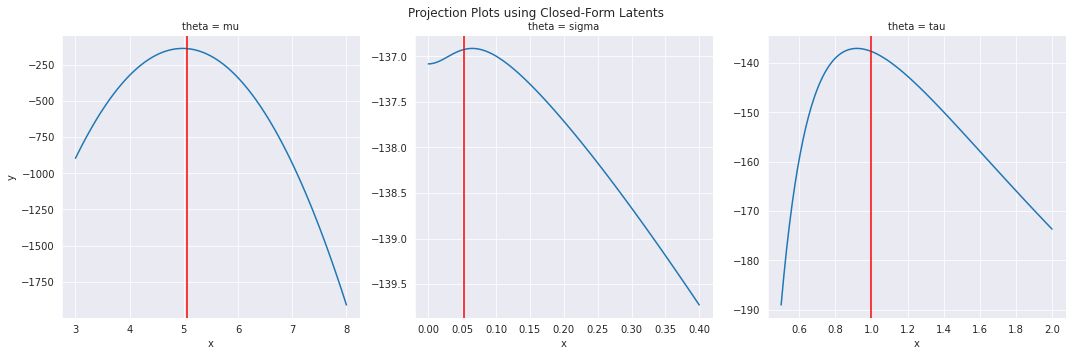

In [ ]:
# plot exact likelihood
theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
#theta_lims = np.array([[3., 8.], [.194, .195], [0, 10]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
plot_df = proj_data(lambda th: bm_loglik(th, y_meas, dt),
                    theta, theta_lims, theta_names, n_pts=n_pts)

rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots using Closed-Form Latents')

rp.axes[0].axvline(theta_hat_exact_orig_scale[0], color='red')
rp.axes[1].axvline(theta_hat_exact_orig_scale[1], color='red')
rp.axes[2].axvline(theta_hat_exact_orig_scale[2], color='red')


In [ ]:
# Check if PD at this mode

hess = hess_fn(theta_hat_exact_orig_scale, y_meas, dt)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print(var_hat)
print(hess)
print(temp)

NameError: name 'hess_fn' is not defined

Now, we average the hessians iteration over iteration to observe whether they eventually converge to a hessian that is positive semidefinite. This is the first method of trying to establish a usable variance estimate for our method.

In [ ]:
# We now try to check whether `averaging(bm_hess(theta)) -> bm_hess_exact(theta)` for the different values of theta = theta_true, theta_hat_exact, theta_hat. 
# params is now theta_hat_exact_orig_scale
hess_avg = jnp.mean(hessian_averaging_alg(theta_hat_exact, key, particle_neg_loglik, y_meas, bm_model,
                            iterations=100, n_particles=1000), axis=0)
hess_exact = hess_fn(theta_hat_exact_orig_scale, y_meas, dt)
# print(hess_avg)
# print(hess_exact)

In [ ]:
# Test Case: theta_true

theta_true = jnp.array([5.0, 0.2, 1.0])
theta_true_unc_scale = jnp.array([theta_true[0], jnp.log(theta_true[1]), 
                                  jnp.log(theta_true[2])])

hess_sim = hessian_averaging_alg(theta_true_unc_scale, key, particle_neg_loglik, y_meas, bm_model,
                                 iterations=1, n_particles=10000)

In [ ]:
hess_fn = jax.jacfwd(jax.jacrev(bm_loglik))
hess_avg2 = jnp.mean(hess_sim, axis=0)
#hess_se = jnp.std(hess_sim, axis=0)
hess_exact2 = -hess_fn(theta_true, y_meas, dt)

print("hess_avg = \n{}".format(hess_avg2))
#print("hess_se = \n{}".format(hess_se))
print("hess_exact = \n{}".format(hess_exact2))

hess_avg = 
[[12028.82326511  -753.1387028   -542.74738355]
 [ -753.1387028     45.58408355    34.92965325]
 [ -542.74738355    34.92965325   172.58574833]]
hess_exact = 
[[ 388.11414279 -290.90233168   -5.69229852]
 [-290.90233168  166.95330986   -1.47053583]
 [  -5.69229852   -1.47053583  169.92209457]]


In [ ]:
hess.shape


(3, 3)

In [ ]:
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print(temp)

False


Unfortunately, we notice that this does not yield a PSD hessian even after 1000 iterations. Therefore, we are not able to obtain a variance estimate here. Next, we shall try to add a value to the diagonal and use that as our estimate. In order for this method to be effective, we try to add the smallest value we possibly can to the diagonal of the hessian.

In [ ]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
additive_const = 1e-2
hess = hessian_fn(params, key, n_particles=1000, y_meas=y_meas, model=bm_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


Original Hessian estimate is positive semidefinite:  False
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


Now, given that this method worked, we generate posteriors for each of our parameters, that is, $\tau, \mu, \sigma$

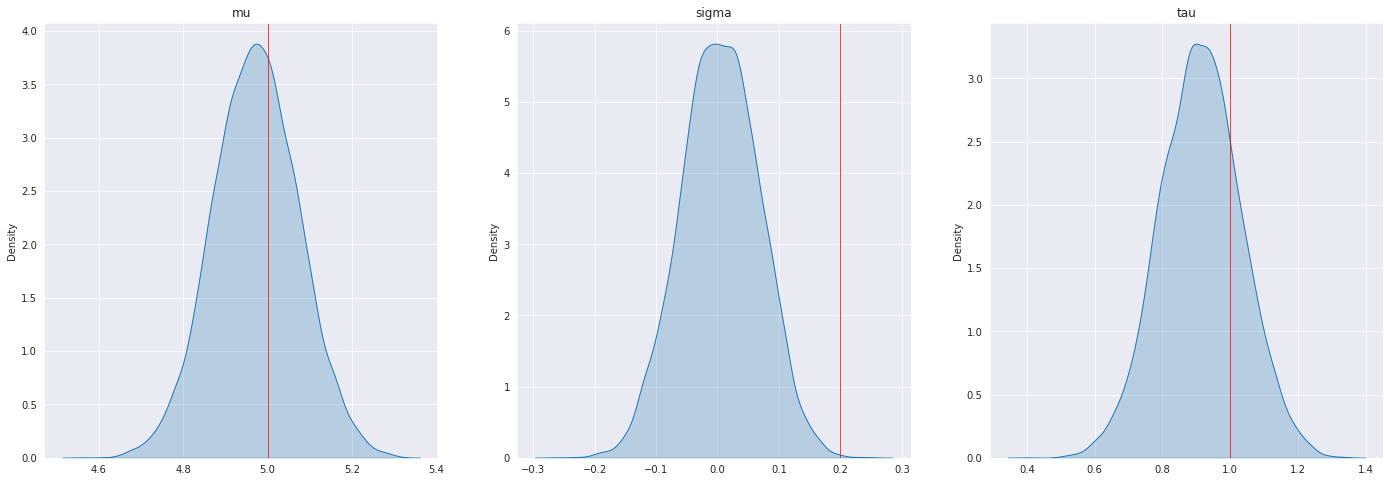

In [ ]:
mle_samples = random.multivariate_normal(key=key, mean=params, cov=var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show()

# Another Trial

In [ ]:
# stochastic objective function
n_particles = 1000
bm_loglik_stock = partial(particle_neg_loglik, n_particles=n_particles, model=bm_model, y_meas=y_meas)

#bm_loglik_stock(theta_true)
theta_true_unc_scale

DeviceArray([ 5.        , -1.60943791,  0.        ], dtype=float64)